# A Good Baseline MNIST Classifier

In Jeremy Howard's fastai lecture #3, (see the full course at [fast.ai](https://course.fast.ai/)), he mentions the importance of baselines.
That is, when you set out to create a classifier that does something non-trivial (intelligent even), make sure that the intelligence-measuring stick you use isn't as dumb as a rock.
For example, while we were grad students at MIT, Ali led several discussion and lab sessions.
In these sessions, baselines were discussed; and you'd be surprised to see how often people suggested "randomly selecting".
That's a *terrible* baseline!
In fact, generally speaking, choosing the most commonly seen example tends to be better than random sampling!

Okay.
So, baselines are important.
Back to fastai.

In the lecture, Howard mentions chosing a good baseline and suggest the following for MNIST:
What if you take a "mean digit" (or "average digit") for each of the ten digits from 0 to 9.
Then, for a given testing example, determine which mean it is closest to.
This seemed like a good idea for a simple baseline, so I decided to write it.

## Prepping the Data

In [1]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

from fastai.vision.widgets import HBox, widget

matplotlib.rc('image', cmap='Greys')

Step 1 in any machine learning or AI task is collecting and preparing the testing data.
Lucky for us, fastai provides many useful functions to help us along with the MNIST data.
Among those are `untar_data` and the `URLs` class.

In [2]:
path = untar_data(URLs.MNIST)

path # let's see where it saved to

Path('/jupyter/cache/data/mnist_png')

Great!
Now we have the data untarred and ready to go on disk.
But we still have to generate the "average digit" or "ideal digit" for each of the ten digits, `0` through `9`.
To do that, we'll create a function, `make_mean`, that grabs each training example of a given type and does a pixel-wise average of each.

In [3]:
def make_mean(path, i):
    '''Given a label, `i`, and location, `path`, generate the "average digit" for each digit, `i`.'''
    files = (path/'training'/str(i)).ls().sorted()
    tensors = [tensor(Image.open(f)) for f in files]
    stacked = torch.stack(tensors).float()/255
    mean = stacked.mean(0)
    return mean

Then (of course) we call `make_mean` for each of the digits $\texttt{i} \in [0,9]$

In [4]:
means = torch.stack([make_mean(path, i) for i in range(10)])

Now we have the "mean images".

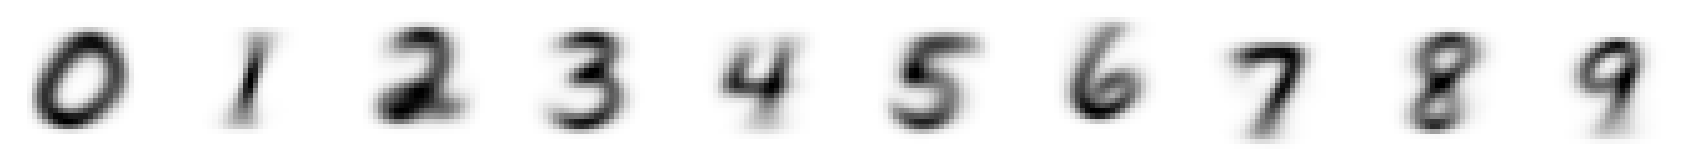

In [5]:
show_images(means)

And indeed, this passes the sniff test!
These "mean digits" are very much as I'd picture the "ideal numbers" in my head.
Especially that 2 and that 6!
Man, I wish I could draw a 6 that perfectly ...

Now that we have the ideal digits, we can even start to get a sense for what our training data looks like.
For example, notice that the 1 kind of resmebles a capitol I?
That must be because some people draw 1s slanted more in one direction, while others tend to draw their 1s slanted in the opposite direction.
As we can see, the net result is an I-like shape.

## Testing

Moving on, we want to find a decent loss function to use as a metric for determining which ideal digit a given test example most closely resembles.
Some good candidates are the $L_1$ and $L_2$ norms.
Given the mean image we're comparing against, $m$, and the training sample we want to compare, $x$, we can write:

$$ L_1 = \sum_{i,j} |m_{i,j} - x_{i,j}| \qquad L_2 = \sqrt{\sum_{i,j} (m_{i,j} - x_{i,j})^2} $$

Where $i$ and $j$ are the pixel indecies into an image.

This next cell defines both the $L_1$ and the $L_2$ norms.
Note that pytorch allows us to make this much simpler by overloading `-` and `*` to stand for element-wise subtraction and multiplication, respectively.

In [6]:
def l1_norm(m, x): return (m - x).abs().mean((-1, -2))

def l2_norm(m, x): return ((m - x)**2).sqrt().mean((-1, -2))

Now before we can actually do the testing, we need to load in the testing data.
Much like before, we just pull these from disk and store them as tensors.

In [7]:
testing = [
    torch.stack([
        tensor(Image.open(f))
        for f in (path/'testing'/str(i)).ls().sorted()
    ]).float()/255
    for i in range(10)
]

And lo and behold, we see that we have varying numbers of each type of digit.

In [8]:
[t.shape for t in testing]

[torch.Size([980, 28, 28]),
 torch.Size([1135, 28, 28]),
 torch.Size([1032, 28, 28]),
 torch.Size([1010, 28, 28]),
 torch.Size([982, 28, 28]),
 torch.Size([892, 28, 28]),
 torch.Size([958, 28, 28]),
 torch.Size([1028, 28, 28]),
 torch.Size([974, 28, 28]),
 torch.Size([1009, 28, 28])]

Now, because I've always been a fan of the sniff test, I think it'd be good to have a look at what these loss functions do to our testing data.

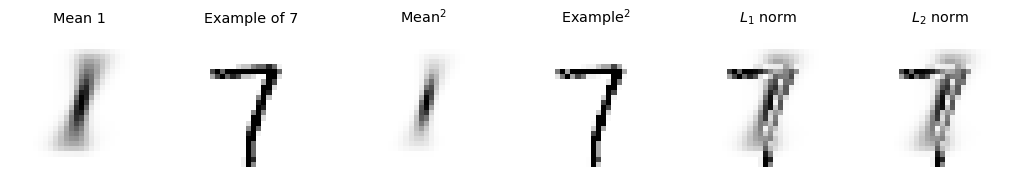

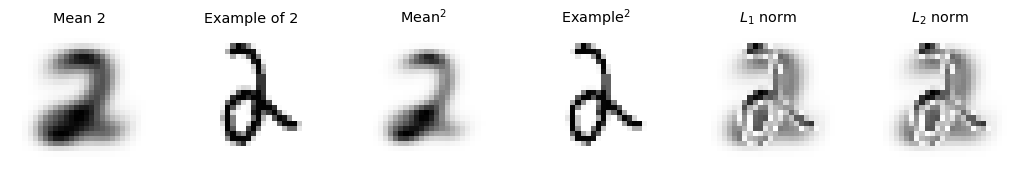

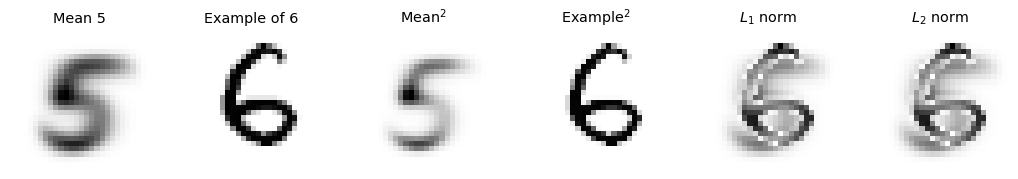

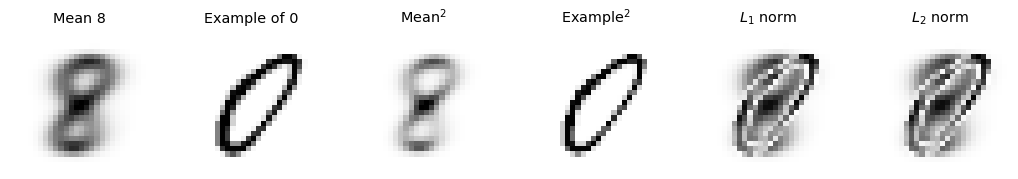

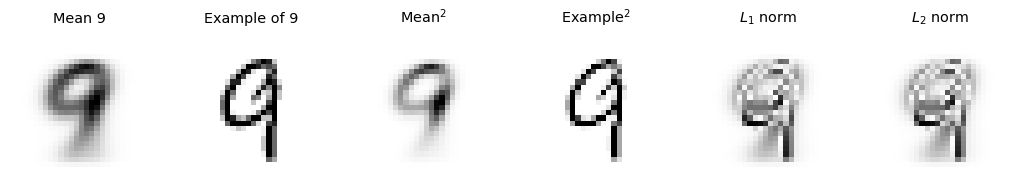

In [9]:
def sniff_test(m, d, i):
    '''
    m: Mean digit to use
    d: Digit to test on
    i: Index of the testing digit.
    '''

    _m = means[m]
    t = testing[d][i]
    l1= (_m-t).abs()
    l2= ((_m-t)**2).sqrt()

    show_images((_m, t, _m*_m, t*t, l1, l2),
                titles=[
                    'Mean '+str(m),
                    'Example of '+str(d),
                    'Mean$^2$',
                    'Example$^2$',
                    '$L_1$ norm',
                    '$L_2$ norm',
                ])

sniff_test(1, 7, 200)
sniff_test(2, 2, 50)
sniff_test(5, 6, 101)
sniff_test(8, 0, 42)
sniff_test(9, 9, 40)

Now we run the "classifier" on each element of the testing set.
The result of each step should be a rank-1 tensor with 10 elements, one for each digit.
These values store our loss for each digit.

Since we wrote both `l1_norm` and `l2_norm`, let's do the evaluation for both.

In [10]:
def evaluate(loss, data):
    return [
        torch.stack([loss(means, t) for t in subset])
        for subset in data
    ]

l1_results = evaluate(l1_norm, testing)
l2_results = evaluate(l2_norm, testing)

Another sanity check: the shapes of the resulting `*_results` lists should be identical:

In [11]:
HBox((widget([r.shape for r in l1_results]), widget([r.shape for r in l2_results])))

Now we make confusion matricies for of all the results we computed in the last step.

In [12]:
def make_conf_mat(results):
    return tensor([
        [sum(1 for r in results[e] if r.argmin() == a) for a in range(10)]
        for e in range(10)    
    ])

l1_conf_mat = make_conf_mat(l1_results)
l2_conf_mat = make_conf_mat(l2_results)

Let's graph them both to compare!

In [13]:
def to_table(mat):
    df = pd.DataFrame(mat)
    return widget(df.style.set_properties(**{'font-size':'12pt'}).background_gradient('Greys'))

HBox((to_table(l1_conf_mat), to_table(l2_conf_mat)))

And lo!
They are the same confusion matrixes!

Indeed, we can ensure this with a simple:

In [14]:
reduce(lambda a,b: a and b, (l1_conf_mat == l2_conf_mat)[0]).item()

True

And that makes sense!
In the $L_1$ and $L_2$ norms we have qualitatively similar metrics.
They both determine similar things to be similiar and similar ways.

So, going forward, we'll use only the first confusion matrix, `l1_conf_mat`.
And we'll rename it to `cm`.

In [15]:
cm = l1_conf_mat

# Statistics

With all this data, we can compute some simple stats.
In case it's been a while, here are the stats we'll compute:

$$\textrm{Accuracy} = \frac{\textrm{True}}{\textrm{All}}
\qquad
\textrm{Sensitivity} = \frac{T_+}{T_+ + F_-}
\qquad
\textrm{Specificity} = \frac{T_-}{T_- + F_+}$$

In [16]:
def compute_stats(cm):
    acc = [
        (cm[i,i] + sum(v for k,row in enumerate(cm)
                         for j,v in enumerate(row)
                         if j != i and k != i)) / cm.sum()
        for i,_ in enumerate(cm)
    ]

    sen = [cm[i,i] / cm[i].sum() for i,_ in enumerate(cm)]

    def comp_spe(idx):
        true_neg = sum(v for i, row in enumerate(cm)
                         for j, v in enumerate(row)
                         if i != idx and j != idx)
        return true_neg / (true_neg + cm[:,idx].sum() - cm[idx,idx])

    spe = [comp_spe(i) for i,_ in enumerate(cm)]
    
    return acc, sen, spe

acc, sen, spe = compute_stats(cm)

In [17]:
def display_stats(acc, sen, spe):
    df = pd.DataFrame(torch.stack(list(map(tensor, zip(acc, sen, spe))))*100,
                      columns=['Accuracy', 'Sensitivity', 'Specificity'])
    return widget(df.style.set_properties(**{'font-size':'12pt'}).format('{:.1f}%'))
    
display_stats(acc, sen, spe)

Output()

# Conclusion

So the takeaway here is that, if you make some classifier that you think is the best thing since sliced bread because (for example) you get a **95% accuracy** on recognizing 0s, well think again.
That 95% accuracy doesn't even outperform this simple classifier that takes nearly no time to run.
So always remember: *choose a good baseline*.

# Some "extra credit"

For kicks, why don't we take a look at how well this baseline performs on the same data as it was trained on?
By now, you know the drill ...

In [18]:
# Read in the data.
data = [
    torch.stack([
        tensor(Image.open(f))
        for f in (path/'training'/str(i)).ls().sorted()
    ]).float()/255
    for i in range(10)
]

# Evaluate the results.
results = evaluate(l1_norm, data)

# Build the confusion matrix.
cm = make_conf_mat(results)

# Compute the stats.
acc, sen, spe = compute_stats(cm)

# Display both!
HBox((to_table(cm), display_stats(acc, sen, spe)))

Unsurprisingly, this doesn't perform much differently than on the testing data.